In [45]:
!pip install statsforecast;

In [46]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')

my_path = "/content/drive/MyDrive/EDAF/Intro_data_forecast/fpp3-python/"
# /content/drive/MyDrive/EDAF/Intro_data_forecast/fpp3-python/Assets

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Distributional forecasts and prediction intervals
***

## Forecast distributions

As discussed, we express the uncertainty in our forecasts using a probability distribution. It describes the probability of observing possible future values using the fitted model. The point forecast is the mean of this distribution. Most time series models produce normally distributed forecasts — that is, we assume that the distribution of possible future values follows a normal distribution. We will look at a couple of alternatives to normal distributions later in this section.

## Prediction intervals
A prediction interval gives an interval within which we expect $y_{t}$ to lie with a specified probability. For example, assuming that distribution of future observations is normal, a 95% prediction interval for the $h$-step forecast is

\begin{gather*}
\hat{y}_{T+h} = ± 1.96 \hat{σ}_{h}
\end{gather*}

where $\hat{σ}_{h}$ is an estimate of the standard deviation of the $h$-step forecast distribution.

More generally, a prediction interval can be written as

\begin{gather*}
\hat{y}_{T+h} = ± c \hat{σ}_{h}
\end{gather*}

where the multiplier $c$ depends on the coverage probability. In this book we usually calculate 80% intervals and 95% intervals, although any percentage may be used. Table 5.1 gives the value of $c$ for a range of coverage probabilities assuming a normal forecast distribution.

Table 5.1: Multipliers to be used for prediction intervals.


| Percentage      | Multiplier |
| ----------- | ----------- |
| 50      | 0.67       |
| 55   | 0.76        |
| 60   | 0.84        |
| 65   | 0.93        |
| 70   | 1.04        |
| 75   | 1.15        |
| 80   | 1.28        |
| 85   | 1.44        |
| 90   | 1.64        |
| 95   | 1.96        |
| 96   | 2.05        |
| 97   | 2.17        |
| 98   | 2.33        |
| 99   | 2.58        |



The value of prediction intervals is that they express the uncertainty in the forecasts. If we only produce point forecasts, there is no way of telling how accurate the forecasts are. However, if we also produce prediction intervals, then it is clear how much uncertainty is associated with each forecast. For this reason, point forecasts can be of almost no value without the accompanying prediction intervals.

## One-step prediction intervals

When forecasting one step ahead, the standard deviation of the forecast distribution can be estimated using the standard deviation of the residuals given by

\begin{gather*}
\hat{σ}= \sqrt{1 /(T - K - M) \sum_{t=1}^{T} {e}_{t}^2}
\end{gather*}

where $K$ is the number of parameters estimated in the forecasting method, and $M$ is the number of missing values in the residuals. (For example, $M=1$ for a naive forecast, because we can’t forecast the first observation.)

For example, consider a naïve forecast for the Google stock price data `google_2015` (shown in Figure 8). The last value of the observed series is 758.88, so the forecast of the next value of the price is 758.88. The standard deviation of the residuals from the naïve method, as given by Equation (5.1), is 11.19. Hence, a 95% prediction interval for the next value of the GSP is

\begin{gather*}
758.88 ± 1.96(11.19) = [736.9,780.8]
\end{gather*}

Similarly, an 80% prediction interval is given by

\begin{gather*}
758.88 ± 1.28(11.19) = [744.5,773.2]
\end{gather*}

The value of the multiplier (1.96 or 1.28) is taken from Table 5.1.

## Multi-step prediction intervals

A common feature of prediction intervals is that they usually increase in length as the forecast horizon increases. The further ahead we forecast, the more uncertainty is associated with the forecast, and thus the wider the prediction intervals. That is, $\hat{σ}_{h}$ usually increases with $h$ (although there are some non-linear forecasting methods which do not have this property).

To produce a prediction interval, it is necessary to have an estimate of $\hat{σ}_{h}$. As already noted, for one-step forecasts $(h = 1)$, Equation (5.1) provides a good estimate of the forecast standard deviation  ${σ}_{1}$. For multi-step forecasts, a more complicated method of calculation is required. These calculations assume that the residuals are uncorrelated.

## Benchmark methods

For the four benchmark methods, it is possible to mathematically derive the forecast standard deviation under the assumption of uncorrelated residuals. If $\hat{σ}_{h}$ denotes the standard deviation of the $h$-step forecast distribution, and $\hat{σ}$ is the residual standard deviation given by (5.1), then we can use the expressions shown in Table 5.2. Note that when $h = 1$ and $T$ is large, these all give the same approximate value $\hat{σ}$.

Table 5.2: Multi-step forecast standard deviation for the four benchmark methods, where $σ$ is the residual standard deviation, $m$ is the seasonal period, and $k$ is the integer part of $(h−1)/m$ (i.e., the number of complete years in the forecast period prior to time $T+h$)

| Benchmark method      | 	 $h$-step forecast standard deviation |
| ----------- | ----------- |
| Mean      | $\hat{σ}_{h} = \hat{σ} \sqrt{1 + 1 / T}$       |
| Naïve   | $\hat{σ}_{h} = \hat{σ} \sqrt{h}$        |
| Seasonal naïve   | $\hat{σ}_{h} = \hat{σ} \sqrt{k + 1}$        |
| Drift   | $\hat{σ}_{h} = \hat{σ} \sqrt{h(1 + h/(T - 1))}$        |


# New section

The `forecast()` and `predict()` functions generate predictions intervals via the `level` argument.

When plotted, the prediction intervals are shown as shaded regions, with the strength of colour indicating the probability associated with the interval. Again, 80% and 95% intervals are shown by default, with other options available via the `level` argument.

In [47]:
#Import the libraries that we are going to use for the analysis:
import pandas as pd
import numpy as np
import random
from itertools import product
from ipywidgets import interact

from statsforecast import StatsForecast
from statsforecast.models import __all__

import matplotlib.pyplot as plt

In [48]:
# Create a dataframe from a csv file:
google_stock = pd.read_csv(my_path + "Assets/GOOGL.csv")

# Filter the year of interest:
google_mask = google_stock["Date"] <= "2015-12-31"
google_2015 = google_stock[google_mask]

# Define a new dataframe with daily close prices and dates:
google_train = google_2015[["Date", "Close"]]

# Rename columns:
google_train.columns = ["ds", "y"]

# Create a new column in the dataframe, unique_id:
google_train["unique_id"] = "Close price"

# Convert string Date time into Python Date time object:
google_train['ds'] = pd.to_datetime(google_train['ds'])

<ipython-input-48-252578147b7a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  google_train["unique_id"] = "Close price"
<ipython-input-48-252578147b7a>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  google_train['ds'] = pd.to_datetime(google_train['ds'])


In [49]:
# import the model that we are going to use for the analysis:
from statsforecast.models import AutoARIMA
from statsforecast.models import SeasonalNaive

# Since we are dealing with daily data, it would be benefitial to use 5 as seasonality.
models = [AutoARIMA(season_length=5, approximation=True), SeasonalNaive(5)]

In [50]:
# Define the model, fit and predict:
sf = StatsForecast( models=models,
                     freq="D",
                     n_jobs=-1,
                    fallback_model = SeasonalNaive(season_length=7))

In [51]:
# We can define the level of the forecast intervals we want to produce. StatsForecast will produce these levels:
levels = [80, 80]

In [52]:
# The forecast function converts the forecast distributions into intervals:
#forecasts = fcst.forecast(df= h=10, level=levels)
forecasts = sf.forecast(df=google_train, h=48, level=[80]);
forecasts.head()


/usr/local/lib/python3.11/dist-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsforecast/arima.py:479: UserWarning: possible convergenc

,unique_id,ds,AutoARIMA,AutoARIMA-lo-80,AutoARIMA-hi-80,SeasonalNaive,SeasonalNaive-lo-80,SeasonalNaive-hi-80
0,Close price,2016-01-01,38.873245,38.155601,39.590890,38.292000,36.633108,39.950892
1,Close price,2016-01-02,38.958243,37.899321,40.017164,39.112000,37.453108,40.770892
2,Close price,2016-01-03,39.035600,37.759726,40.311474,39.698002,38.039110,41.356894
3,Close price,2016-01-04,39.107427,37.669454,40.545400,39.514999,37.856107,41.173891
4,Close price,2016-01-05,39.175250,37.606055,40.744446,38.900501,37.241609,40.559393


In [53]:
# Reset the index of the DataFrame, and use the default one instead:
forecasts = forecasts.reset_index()

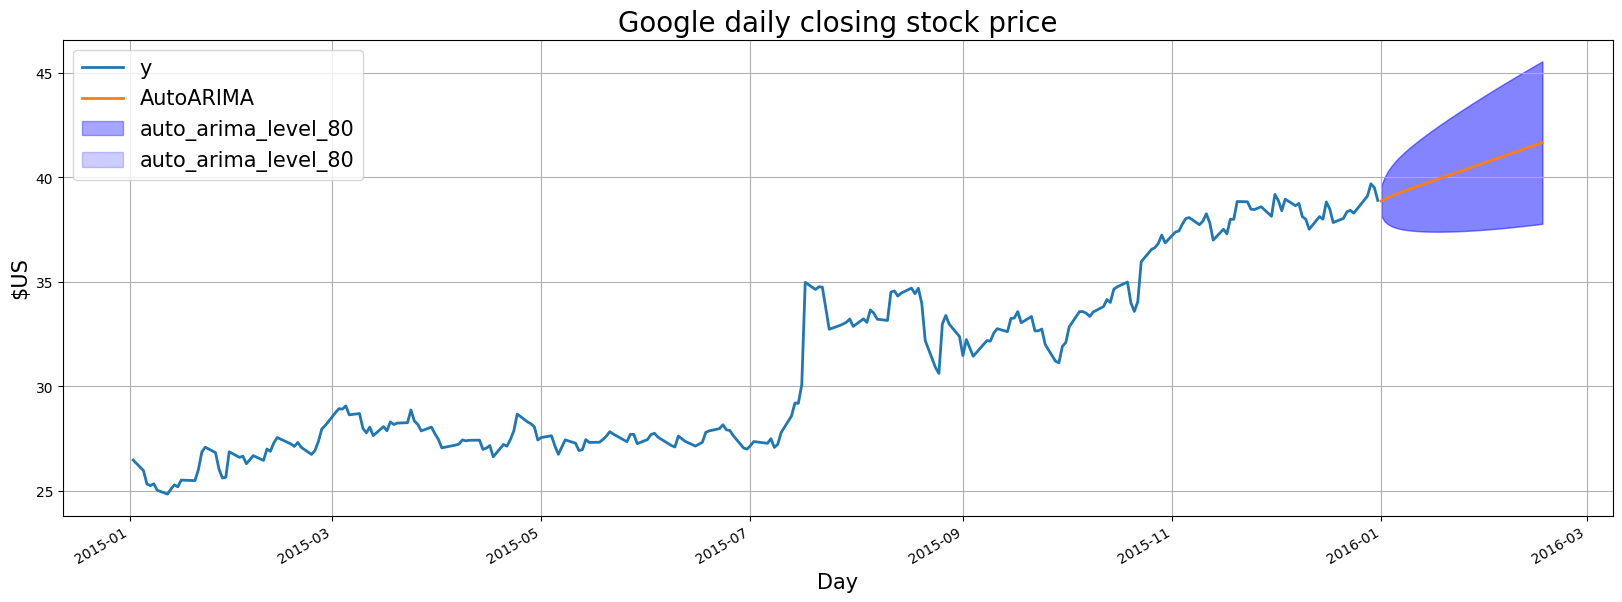

In [54]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))

# Concatenate the dataframe of predicted values with the dataframe of observed values:
df_plot = pd.concat([google_train, forecasts]).set_index('ds')
df_plot[['y', 'AutoARIMA']].plot(ax=ax, linewidth=2)

# Specify graph features:
ax.fill_between(df_plot.index,
                df_plot['AutoARIMA-lo-80'],
                df_plot['AutoARIMA-hi-80'],
                alpha=.35,
                color='blue',
                label='auto_arima_level_80')
ax.fill_between(df_plot.index,
                df_plot['AutoARIMA-lo-80'],
                df_plot['AutoARIMA-hi-80'],
                alpha=.2,
                color='blue',
                label='auto_arima_level_80')
ax.set_title('Google daily closing stock price', fontsize=20)
ax.set_ylabel('$US', fontsize=15)
ax.set_xlabel('Day', fontsize=15)
ax.legend(prop={'size': 15})
ax.grid()


<p style="text-align: center;">Figure 14: 80% and 95% prediction intervals for the Google closing stock price based on a naïve method.</p>